#  Building a Spam Filter with Naive Bayes algorithm
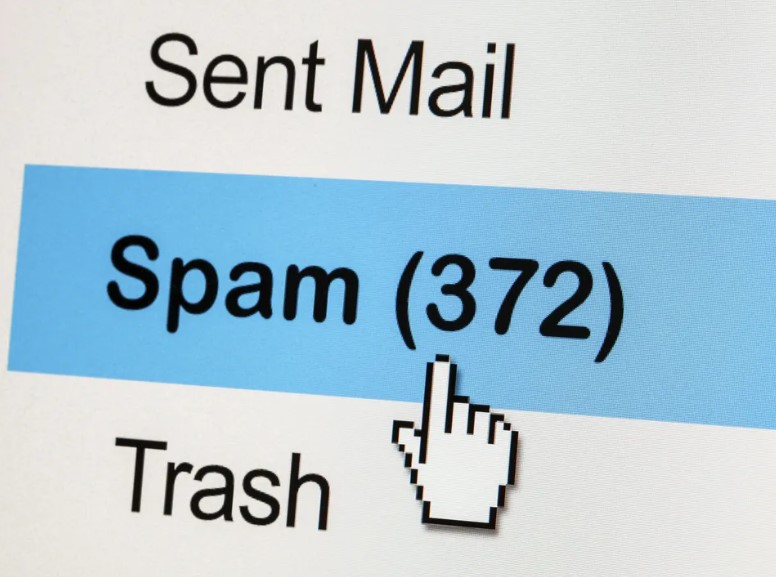
## Introduction

In this guided project, we're going to study the practical side of the Naive Bayes algorithm by building a spam filter for SMS messages.

In order to classify messages as spam or non-spam the computer usually follows the logic below:
1. Learns how humans classify messages.
2. Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
3. Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).



## 1. Teaching computer how humans classify messages

### Using Bayes algorithm with existing dataset

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from __[The UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)__

In [1]:
import pandas as pd # Importing data set
data = pd.read_csv('SMSSpamCollection', sep='\t', header = None, names = ['Label', 'SMS'])


### Data exploration

In [2]:
# Exploring the dataset and finding the number of rows and columns 
print(data.shape) 
data.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Finding amount of spam and non-spam ('ham') messages
data['Label'].value_counts() 

ham     4825
spam     747
Name: Label, dtype: int64

In [4]:
# Finding the percentage of spam and non-spam messages
data['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

More than 86% of messages out of 5,572 are not classified as spam and 13% respectively are spam.

We should randomize the dataset to make sure spam and non-spam messages distributed randomly throughout the set.

In [5]:
data_rand = data.sample(frac = 1, random_state = 1) 
# frac=1 parameter to randomize the set; randome_state=1 to make sure results are reproducible

data_rand.head(20)

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...
5461,ham,Ok i thk i got it. Then u wan me 2 come now or...
4210,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...
4216,ham,No dear i was sleeping :-P
1603,ham,Ok pa. Nothing problem:-)
1504,ham,Ill be there on &lt;#&gt; ok.


### Splitting the data
Before we create our spam filter, we should think of a way to test how well it works. Before that we should split our dataset into training set which we will use to ‘train’ the software how to classify messages. We are going to allocate 80% of the dataset for the training set. Remaining 20% will be allocated towards the testing our software. 

In [6]:
# Creating training index for splitting data 80/20
training_set_index = round(len(data) * 0.8)
print(training_set_index)

4458


In [7]:
# Reseting index labels using df.reset_index() method
training_set = data_rand[:training_set_index].reset_index(drop=True) # drop=True - dropping initial index
training_set.shape


(4458, 2)

In [8]:
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [9]:
testing_set = data_rand[training_set_index:].reset_index(drop=True)
testing_set.shape

(1114, 2)

In [10]:
testing_set.head()

,Label,SMS
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


We should find the percentage of spam and ham in both training & testing sets and compare to the initial dataset. 

In [11]:
print(' Testing set')
print(testing_set['Label'].value_counts(normalize=True))
print('\n','Training set')
print(training_set['Label'].value_counts(normalize=True))
print('\n','Dataset')
print(data['Label'].value_counts(normalize=True))

 Testing set
ham     0.868043
spam    0.131957
Name: Label, dtype: float64

 Training set
ham     0.86541
spam    0.13459
Name: Label, dtype: float64

 Dataset
ham     0.865937
spam    0.134063
Name: Label, dtype: float64


As we can see the percentages of both sets are similar to initial dataset.

### Data Cleaning

Now we need to perform some data cleaning to bring the data to a format that will allow us to extract easily all the information needed to calculate probabilities for our sets. 

We should bring the data to the format where each column represents a unique word from the vocabulary. Each row describes a single message in a format of values corresponding to the number of times each word from the dictionary occurs in the message. In other words the frequency of that unique word for any given message. Punctuation will not be taken into account. 

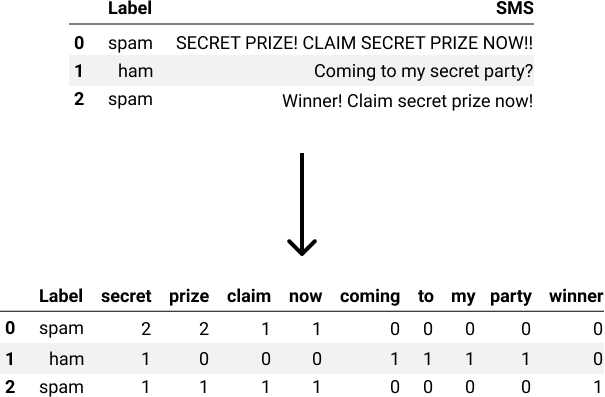


In [12]:
# We begin by removing the punctuation and bringing all the words to lower case.
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ').str.lower() 
# In Regex Syntax '\W' matches any character which is not a word character


In [13]:
# Checking our results
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [14]:
# Transforming each message into a list by splitting the string at the space character
training_set['SMS'] = training_set['SMS'].str.split()

In [15]:
# Creating new vocabulary list with all the unique words in our training set.
vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
# Transforming the list into the set with unique values and back to the list
vocabulary = list(set(vocabulary))

print(vocabulary[:10])

len(vocabulary)

['plumbing', 'stitch', 'sim', '08700469649', 'thirunelvali', 'anyplaces', '09065069154', 'proof', 'traditions', 'pookie']


7783

We created the vocabulary with unique words from the messages in the training set. 
Now we should create a dictionary that we will then convert to the DataFrame we need.

In [16]:
# Initializing dictionary using Dictionary Comprehensions
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}
# [0] * len(training_set['SMS']) outputs the a list of the lenght of training_set['SMS'] where 
# each element is 0

# We loop using the enumerate() function to get both the index and the SMS message
for index, sms in enumerate(training_set['SMS']): 
    for word in sms:
        word_counts_per_sms[word][index] += 1

# Validating our results by printing random words from first five SMS messages (as seen above) 
print('yep', word_counts_per_sms['yep'][0:5])
print('princess', word_counts_per_sms['princess'][0:5])
print('welp', word_counts_per_sms['welp'][0:5])
print('havent', word_counts_per_sms['havent'][0:5])
print('smth', word_counts_per_sms['smth'][0:5])

yep [1, 0, 0, 0, 0]
princess [0, 1, 0, 0, 0]
welp [0, 0, 1, 0, 0]
havent [0, 0, 0, 1, 0]
smth [0, 0, 0, 0, 2]


In [17]:
len(word_counts_per_sms)

7783

In [18]:
# Transforming results into a DataFrame
data = pd.DataFrame(word_counts_per_sms)

In [19]:
# Concatenating the DataFrame above with the DataFrame containing the training set
training_set_clean = pd.concat([training_set, data], axis = 1)
# Checking our results
training_set_clean.head()

,Label,SMS,plumbing,stitch,sim,08700469649,thirunelvali,anyplaces,09065069154,proof,...,aspects,9am,stuffing,still,family,marsms,celebration,office,dumb,horny
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Estimating probabilities for new messages

Now we begin creating the spam filter. 
According to the Naive Bayes algorithm we need to know the probability values of the two equations below to be able to classify new messages:
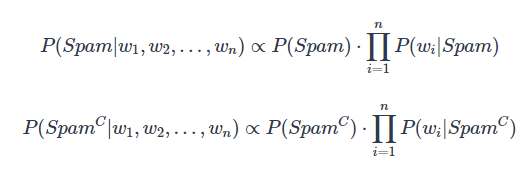

To calculate P(wi|Spam) and P(wi|SpamC), we need to use the additive smoothing technique:

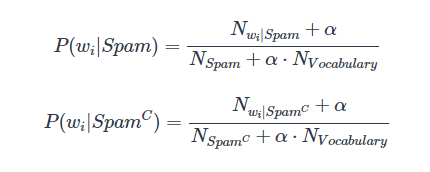


- NSpam is equal to the number of words in all the spam messages

- NHam is equal to the number of words in all the non-spam messages 

- NVocabulary is a total number of words in vocabulary

- α = 1 Laplace smoothing parameter set to 1

### Calculating P(Spam), P(Ham) and number of words

In [20]:
# Separating non-spam dataset
ham = training_set_clean[training_set_clean['Label']=='ham']
print(len(ham))

3858


In [21]:
# Separating spam dataset
spam = training_set_clean[training_set_clean['Label']=='spam']
print(len(spam))

600


In [22]:
# Calculating probability of spam messages
p_spam = len(spam)/len(training_set_clean['Label'])
print(p_spam)

0.13458950201884254


In [23]:
# Calculating probability of non-spam messages
p_ham = len(ham)/len(training_set_clean['Label'])
print(p_ham)

0.8654104979811574


In [24]:
# Calculating number of words in spam and non-spam messages
n_spam_words = spam['SMS'].apply(len).sum()
print('spam words', n_spam_words)

n_ham_words = ham['SMS'].apply(len).sum()
print('non-spam words', n_ham_words)

spam words 15190
non-spam words 57237


In [25]:
# Total number of words in vocabulary
n_total_words = len(vocabulary)
print(n_total_words)

7783


In [26]:
# Initiating Laplace smoothing variable
alpha = 1

### Calculating parameters

We can use our training set to calculate the probability for each word in our vocabulary using formulas:

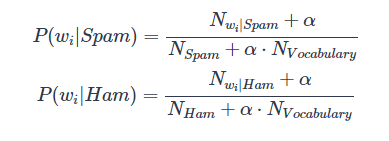

The fact that we calculate so many values before even beginning the classification of new messages makes the Naive Bayes algorithm very fast (especially compared to other algorithms). When a new message comes in, most of the needed computations are already done, which enables the algorithm to almost instantly classify the new message.


In [27]:
# Initializing new dictionaries for P(Wi|Spam) and P(Wi|Ham) using Dictionary Comprehensions
p_w_spam = {unique_word: 0 for unique_word in vocabulary}
p_w_ham = {unique_word: 0 for unique_word in vocabulary}

In [28]:
# Iterating over vocabulary and calculating parameters using above formulas
for word in vocabulary:
    p_w_ham[word] = (ham[word].sum() + alpha)/(n_ham_words + alpha * n_total_words)
    p_w_spam[word] = (spam[word].sum() + alpha)/(n_spam_words + alpha * n_total_words) 

In [29]:
# Verifying our results by checking probability of word ‘free’ being spam or non-spam 
print('Probability of word ‘free’ being spam', p_w_spam['free'])
print('Probability of word ‘free’ being non-spam', p_w_ham['free'])

Probability of word ‘free’ being spam 0.00766116745745005
Probability of word ‘free’ being non-spam 0.0007536142725315288


## 3. Classifying a new message based on probability values
### Creating the spam filter function using these two equations:
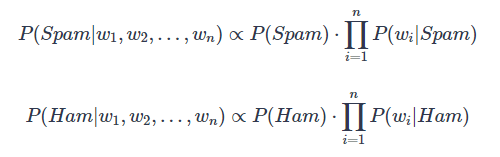

In [30]:
import re # Importing regular expression module

def classify(message): 

    message = re.sub('\W', ' ', message) # Removes punctuation using re.sub() function
    message = message.lower() # Brings all letters to lower case
    message = message.split() # Splits string at the space character and transform it into a list 

    # The function calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
    p_spam_given_message = p_spam 
    p_ham_given_message = p_ham
    for word in message:
        if word in spam:
            p_spam_given_message *= p_w_spam[word]
        if word in ham:
            p_ham_given_message *= p_w_ham[word]
        
        # Some new messages will contain words that are not part of the vocabulary.
        # We should simply ignore these words when we're calculating the probabilities
    
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    # Lastly the function compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [31]:
# Verifying the output of our function by testing evidently spam and non-spam messages 
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [32]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


### Measuring the Spam Filter's Accuracy
We should adjust the classify() function to return labels, which we then will be able to compare with the actual label classified by humans.

In [33]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in spam:
            p_spam_given_message *= p_w_spam[word]

        if word in ham:
            p_ham_given_message *= p_w_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'
    #  We now have return statements instead of print() functions

In [34]:
# Creating a new column in our testing set
testing_set['predicted'] = testing_set['SMS'].apply(classify_test_set)
testing_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we should compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use accuracy as a metric:
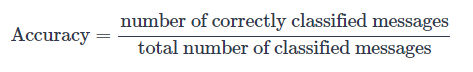

In [35]:
correct = 0
total = testing_set.shape[0]

for row in testing_set.iterrows():
    row = row[1]
    if row['predicted'] == row['Label']:
        correct += 1
        
accuracy = correct/total
print(accuracy)

0.9874326750448833


## Conclusion
In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. We initially aimed for an accuracy of over 80%, but we managed to increase this figure.
